In [2]:
import deepchem as dc
from molgan import BasicMolGANModel as MolGAN
from deepchem.models.optimizers import ExponentialDecay
from tensorflow import one_hot

In [3]:
import pandas as pd

In [4]:
smilesDF = pd.read_csv('Qsmiles.txt', delimiter = '\n', header = None)
smilesDF

,0
0,OC12CC(C1)C1CC2O1
1,CCC1CN1CC(N)=O
2,N#CC(CO)NC1CC1
3,O=Cn1cn[nH]c1=O
4,CC(O)c1ncon1
...,...
4984,CC1CC(C)C2CC1C2
4985,CCCn1ccnn1
4986,C#CC12CCC1(OC)C2
4987,CC1C(C)C2C1C2(C)O


In [5]:
smilesList = list(smilesDF[0])
smilesList

['OC12CC(C1)C1CC2O1',
 'CCC1CN1CC(N)=O',
 'N#CC(CO)NC1CC1',
 'O=Cn1cn[nH]c1=O',
 'CC(O)c1ncon1',
 'COCC1OC1(C)C#N',
 'N#CC1(C#N)C2CNC21',
 'O=CC12C3CC1C2C3=O',
 'O=C1NC=CC12CC2O',
 'O=CC12C3CCN1C2C3',
 'N#CC1CC2C3CN2C13',
 'C1OC2C3OC4C3CC142',
 'CC1=CC(=O)C(=O)C1',
 'COC1CC2CCOC21',
 'CC1C2C(O)C3C2C13C',
 'CN1CC(O)(C=O)C1=O',
 'C1OCC12CC21COC1',
 'COc1nocc1C',
 'C#CC(C)(O)C1OC1C',
 'CC(C)C#CC1NC1C',
 'CN1C=NC(C=O)[C]1[NH]',
 'C1OC2C1C1OC21',
 'CCCC1(OC)CC1C',
 'CC1C(C#N)[N][CH]N1C',
 'CC(=O)c1conc1O',
 'COC1=NC2C(N)C2N1',
 'c1noc2c1C1CC2O1',
 'N#CC1=NCC=C([NH])N1',
 'CC1CC2(CC#N)NC12',
 'CC12CC(O1)C1(O)CC21',
 'O=C1C2CC1C21CC1O',
 'CNC(=O)NCCC#N',
 'C1CC2C3CC2(C1)CO3',
 'C1=CC23COC2C1CO3',
 'CN(C=O)C1CC1C#N',
 'O=CC12CC3CC(C1)N32',
 'OC1(C#CC2CO2)CC1',
 'CC12C=CC(C=CC1)O2',
 'CC1C2C(C)C1C2C=O',
 'CCC12CC3C(C1C)C32',
 'CC1=NOC=N[C]1[NH]',
 'CCC1Cc2ncnn21',
 'NC1=NCCN1C=O',
 'N#CC1CN=C(N)O1',
 'C#CC(CC)CNC=O',
 'NC1=CC(=O)C(=O)NC1',
 'Cc1n[nH]c(C#N)c1N',
 'CCC1N2CC1(C#N)C2',
 'CC1C2C(=O)

# Classical molGAN implementation

In [8]:
smiles = smilesList
feat = dc.feat.MolGanFeaturizer()
features = feat.featurize(smiles)
features = list(filter(lambda x: x is not None, features))

In [7]:
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}
gan.fit_gan(iterbatches(8), generator_steps=0.2, checkpoint_interval=5000)
generated_data = gan.predict_gan_generator(10)
# convert graphs to RDKitmolecules
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))
# remove invalid moles
nmols = list(filter(lambda x: x is not None, nmols))
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

Ending global_step 399: generator average loss -4.20409, discriminator average loss -3.65412
TIMING: model fitting took 25.408 s
Generating 10 samples
10 molecules generated
7 valid molecules


RDKit ERROR: [12:23:53] Explicit valence for atom # 3 F, 3, is greater than permitted
RDKit ERROR: [12:23:53] Explicit valence for atom # 5 C, 7, is greater than permitted


# Implementing the Quantum Lambda Activation Function

In [12]:
from qiskit import IBMQ
#from qiskit_rng import Generator

In [13]:
from qiskit.circuit import library

In [26]:
from qiskit_rng import Generator

In [27]:
IBMQ.save_account('63be3fbcd17706e675343eaca5c11964a916885ae585d2acdfdfdc476671eebbd3c47db6213f526255be9612a9389413162ca3bdd8862bbd6aa086549b44849f')

In [29]:
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_qasm_simulator')

In [30]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute,IBMQ
from qiskit.tools.monitor import job_monitor


provider = IBMQ.get_provider()

q = QuantumRegister(16,'q')
c = ClassicalRegister(16,'c')
circuit = QuantumCircuit(q,c)
circuit.h(q) # Applies hadamard gate to all qubits
circuit.measure(q,c) # Measures all qubits 

backend = provider.get_backend('ibmq_qasm_simulator')
job = execute(circuit, backend, shots=1100)
                               
print('Executing Job...\n')                 
job_monitor(job)
counts = job.result().get_counts()

print('RESULT: ',counts,'\n')
print('Press any key to close')
input()

Executing Job...

Job Status: job has successfully run
RESULT:  {'0001000001011000': 1, '0001000001100011': 1, '0000000100000111': 1, '0001000010000000': 1, '0001000010110001': 1, '0001000011011011': 1, '0001000011110011': 1, '0001000011111010': 1, '0001000100001101': 1, '0001000100001111': 1, '0001000101011100': 1, '0001000101100101': 1, '0001000110010011': 1, '0001001000001101': 1, '0001001001001110': 1, '0001001010001101': 1, '0001001011001000': 1, '0001001100011000': 1, '0001001101001110': 1, '0001010000000100': 1, '0001010000001001': 1, '0001010010101111': 1, '0001010011001000': 1, '0001011000000000': 1, '0001011010011001': 1, '0001011100011010': 1, '0001011101110110': 1, '0001011101111101': 1, '0001011111101000': 1, '0001100001101100': 1, '0001100010101111': 1, '0001100100000010': 1, '0001100100011101': 2, '0001100100110101': 1, '0001100110010010': 1, '0001100111000101': 1, '0001100111001011': 1, '0001101000000001': 1, '0001101000001001': 1, '0001101000110011': 1, '00011010001110

''

# Data Preprocessing

In [31]:
import numpy as np

In [33]:
def binaryToDecimal(binary): 
    return int(binary,2)

In [34]:
randNums = []
for i in range(len(counts)):
    randNums.append(binaryToDecimal(counts.popitem()[0]))
randNums

[65460,
 65433,
 65408,
 65357,
 65306,
 65299,
 65237,
 65191,
 65189,
 64936,
 64924,
 64877,
 64802,
 64799,
 64767,
 64720,
 64712,
 64673,
 64629,
 64607,
 64505,
 4025,
 64398,
 64338,
 64333,
 64259,
 64173,
 4003,
 64034,
 64010,
 63783,
 63776,
 63744,
 63737,
 63669,
 63608,
 63576,
 63537,
 63463,
 63454,
 3960,
 63336,
 63202,
 63136,
 63057,
 62990,
 62925,
 62759,
 62743,
 62638,
 62485,
 62402,
 62297,
 3892,
 62233,
 62119,
 62019,
 61900,
 61840,
 61838,
 61715,
 61713,
 61702,
 61519,
 61508,
 61472,
 61271,
 61219,
 61143,
 61133,
 61094,
 61028,
 61005,
 60981,
 60971,
 60951,
 60870,
 60823,
 60767,
 60742,
 60698,
 60671,
 60634,
 60568,
 60480,
 60476,
 60417,
 60396,
 60361,
 60277,
 60199,
 60100,
 60074,
 60037,
 60026,
 59984,
 59926,
 59791,
 59779,
 59768,
 59745,
 59740,
 59672,
 59655,
 59627,
 59538,
 59510,
 59474,
 59452,
 59444,
 3703,
 59245,
 59218,
 3699,
 59172,
 59014,
 58962,
 58885,
 58840,
 58762,
 58732,
 58589,
 58538,
 58380,
 58307,
 58117

In [35]:
len(counts)

0

In [36]:
a = np.array(randNums)
a

array([65460, 65433, 65408, ...,   263,  4195,  4184])

In [37]:
counts1 = np.array(randNums)[0:1000]
counts1

array([65460, 65433, 65408, 65357, 65306, 65299, 65237, 65191, 65189,
       64936, 64924, 64877, 64802, 64799, 64767, 64720, 64712, 64673,
       64629, 64607, 64505,  4025, 64398, 64338, 64333, 64259, 64173,
        4003, 64034, 64010, 63783, 63776, 63744, 63737, 63669, 63608,
       63576, 63537, 63463, 63454,  3960, 63336, 63202, 63136, 63057,
       62990, 62925, 62759, 62743, 62638, 62485, 62402, 62297,  3892,
       62233, 62119, 62019, 61900, 61840, 61838, 61715, 61713, 61702,
       61519, 61508, 61472, 61271, 61219, 61143, 61133, 61094, 61028,
       61005, 60981, 60971, 60951, 60870, 60823, 60767, 60742, 60698,
       60671, 60634, 60568, 60480, 60476, 60417, 60396, 60361, 60277,
       60199, 60100, 60074, 60037, 60026, 59984, 59926, 59791, 59779,
       59768, 59745, 59740, 59672, 59655, 59627, 59538, 59510, 59474,
       59452, 59444,  3703, 59245, 59218,  3699, 59172, 59014, 58962,
       58885, 58840, 58762, 58732, 58589, 58538, 58380, 58307, 58117,
       58086, 58062,

# GAN with Quantum Lambda Fucntion

In [40]:
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000))
dataset = dc.data.NumpyDataset([x.adjacency_matrix for x in features],[x.node_features for x in features])
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]:node_tensor}
gan.fit_gan(iterbatches(20), generator_steps=0.2, checkpoint_interval=5000)

inNoise = np.array(randNums)

generated_data = gan.predict_gan_generator(noise_input = np.reshape(counts1,(100,10)))

# convert graphs to RDKitmolecules
nmols = feat.defeaturize(generated_data)
print("{} molecules generated".format(len(nmols)))
# remove invalid moles
nmols = list(filter(lambda x: x is not None, nmols))
# currently training is unstable so 0 is a common outcome
print ("{} valid molecules".format(len(nmols)))

Ending global_step 999: generator average loss -22.3265, discriminator average loss -10.7346
TIMING: model fitting took 51.994 s
Generating 100 samples
100 molecules generated
96 valid molecules


RDKit ERROR: [12:46:30] Explicit valence for atom # 0 C, 7, is greater than permitted
RDKit ERROR: [12:46:30] Explicit valence for atom # 0 C, 5, is greater than permitted
RDKit ERROR: [12:46:30] Explicit valence for atom # 0 C, 7, is greater than permitted
RDKit ERROR: [12:46:30] Explicit valence for atom # 0 C, 6, is greater than permitted


# Visualization

In [19]:
tempMols = nmols
tempMols

In [20]:
from rdkit.Chem import Draw

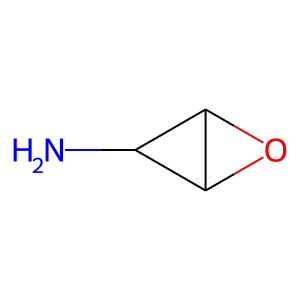

In [24]:
Draw.MolToImage(tempMols[4])

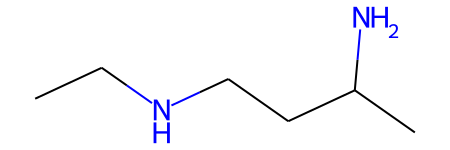

In [170]:
tempMols[1]